In [146]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [147]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")

  0%|          | 0/18 [00:00<?, ?it/s]

In [148]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [149]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]

        graph = dglgraph(problem, gamma, delta).to(device)
        graph = dglgraph_fixed(graph)
        # graph.edata["feat"][os_type][:, 0] /= 10
        # graph.edata["feat"][ss_type] /= 100
        return graph

In [150]:
def parse_idx(string):
    number = re.search(r'\d+', string).group()
    return int(number)

solved_indexes = np.unique([parse_idx(l) for l in glob('solutions/*')])

In [151]:
info = {}
for idx in solved_indexes:
    if f'solutions/gamma_{idx}.npy' in glob('solutions/*'):
        info[idx] = {}
        info[idx]['gamma'] = np.load(f'solutions/gamma_{idx}.npy')
        info[idx]['delta'] = np.load(f'solutions/delta_{idx}.npy')

In [178]:
train_idx, test_idx = train_test_split(solved_indexes,
                                       random_state=42,train_size=0.7)

In [179]:
train_dataset = GraphDataset([dataset[i] for i in train_idx],
                             [info[i]['gamma'] for i in train_idx],
                             [info[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([dataset[i] for i in test_idx],
                            [info[i]['gamma'] for i in test_idx],
                            [info[i]['delta'] for i in test_idx])

In [259]:
train_loader = GraphDataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=2, shuffle=True)

In [260]:
def validate_objective(model, dataset):
    test_objvalue = []
    for i in range(len(dataset.problems)):
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
        test_objvalue.append(
            objvalue(dataset.problems[i], pred_gamma, pred_delta)
        )
    return np.mean(test_objvalue)

In [261]:
def plot_loss(losses_info):
    keys = [key for key in losses_info.keys() if 'loss' in key]
    for key in keys:
        plt.plot(losses_info[key], label=key)
        print(f'min {key} loss: ', min(losses_info[key]))
        plt.legend()
    plt.show()

def plot_objvalue(losses_info):
    keys = [key for key in losses_info.keys() if 'objvalue' in key]
    for key in keys:
        plt.plot(losses_info[key], label=key)
        plt.legend()
        print(f'min {key} objvalue: ', min(losses_info[key]))
    plt.show()

def print_info(info):
    plot_loss(info)
    plot_objvalue(info)

In [262]:
import dgl.function as fn
from dgl.sampling import sample_neighbors
import torch
import torch.nn as nn
from torch.nn import functional as F
from cloudmanufacturing.graph import ss_type, os_type, so_type
import numpy as np

def cat_s_ss(edges):
    return {'s_ss': torch.cat([edges.src['s_feat'], edges.data['feat']], dim=1)}

def cat_o_os(edges):
    return {'o_os': torch.cat([edges.src['o_feat'], edges.data['feat']], dim=1)}

def cat_h_os_s(edges):
    return {'h_os_s': torch.cat([edges.data['h_os'], edges.dst['h_s']], dim=1)}

def cat_h_ss_s(edges):
    return {'h_ss_s': torch.cat([edges.data['h_ss'], edges.dst['h_s']], dim=1)}

def edge_den_os(nodes):
    return {'den_os': torch.sum(torch.exp(nodes.mailbox['e_os']), dim=1)}

def edge_den_ss(nodes):
    return {'den_ss': torch.sum(torch.exp(nodes.mailbox['e_ss']), dim=1)}

def sample_so(graph, logits):
    with graph.local_scope():
        graph.edata['prob'] = {'so': torch.sigmoid(logits)}
        subg = sample_neighbors(
            graph, 
            nodes={'o': graph.nodes('o')}, 
            fanout={'backward': 0, 'forward': 0, 'os': 0, 'so': 1, 'ss': 0},
            prob='prob'
        )
        return subg.edges(etype='so')

class AttnConvLayer(nn.Module):
    def __init__(self, s_shape, o_shape,
                 os_shape, ss_shape, out_dim):
        super().__init__()
        self.delta = nn.Linear(out_dim, 10)
        self.W_s = nn.Linear(s_shape, out_dim)
        self.W_os = nn.Linear(os_shape, out_dim)
        self.W_ss = nn.Linear(ss_shape, out_dim)
        self.attn = nn.Linear(out_dim * 2, 1)
        self.W_in = nn.Linear(o_shape, out_dim)
        self.W_self = nn.Linear(o_shape, out_dim)
        self.W_out = nn.Linear(o_shape, out_dim)
        self.W_o = nn.Linear(out_dim*3, out_dim)

    def forward(self, graph, s_feat, o_feat):
        with graph.local_scope():
            z = self._conv_z(graph, s_feat, o_feat)
            x = self._conv_x(graph, o_feat)
            delta_logits = self._conv_delta(graph)
        return z, x, delta_logits

    def _conv_delta(self, graph):
        return self.delta(torch.relu(graph.edata['h_ss'][ss_type]))

    def _conv_z(self, graph, s_feat, o_feat):
        graph.ndata['s_feat'] = {'s': s_feat}
        graph.ndata['o_feat'] = {'o': o_feat}

        graph.apply_edges(cat_s_ss, etype='ss')
        graph.apply_edges(cat_o_os, etype='os')

        graph.edata['h_ss'] = {'ss': self.W_ss(graph.edata['s_ss'][ss_type])}
        graph.edata['h_os'] = {'os': self.W_os(graph.edata['o_os'][os_type])}
        
        graph.ndata['h_s'] = {'s': self.W_s(s_feat)}

        graph.apply_edges(cat_h_ss_s, etype='ss')
        graph.apply_edges(cat_h_os_s, etype='os')

        graph.edata['e_ss'] = {'ss': F.leaky_relu(self.attn(graph.edata['h_ss_s'][ss_type]))}
        graph.edata['e_os'] = {'os': F.leaky_relu(self.attn(graph.edata['h_os_s'][os_type]))}

        graph.multi_update_all({
            'os': (fn.copy_e('e_os', 'e_os'), edge_den_os),
            'ss': (fn.copy_e('e_ss', 'e_ss'), edge_den_ss),
        }, 'sum')

        graph.edata['nom_os'] = {'os': torch.exp(graph.edata['e_os'][os_type])}
        graph.edata['nom_ss'] = {'ss': torch.exp(graph.edata['e_ss'][ss_type])}

        graph.apply_edges(fn.e_div_v('nom_os', 'den_os', 'alpha_os'), etype='os')
        graph.apply_edges(fn.e_div_v('nom_ss', 'den_ss', 'alpha_ss'), etype='ss')

        graph.edata['alpha_h_ss'] = {'ss': graph.edata['alpha_ss'][ss_type] * graph.edata['h_ss'][ss_type]}
        graph.edata['alpha_h_os'] = {'os': graph.edata['alpha_os'][os_type] * graph.edata['h_os'][os_type]}

        graph.multi_update_all({
            'ss': (fn.copy_e('alpha_h_ss', 'alpha_h_ss'), fn.sum('alpha_h_ss', 'z_ss')),
            'os': (fn.copy_e('alpha_h_os', 'alpha_h_os'), fn.sum('alpha_h_os', 'z_os')),
        }, 'sum')

        z = graph.ndata['z_ss']['s'] + graph.ndata['z_os']['s']
        return z

    def _conv_x(self, graph, o_feat):
        graph.ndata['h_in'] = {'o': self.W_in(o_feat)}
        graph.ndata['h_self'] = {'o': self.W_self(o_feat)}
        graph.ndata['h_out'] = {'o': self.W_out(o_feat)}

        graph.multi_update_all({
            'forward': (fn.copy_u('h_in', 'h_in'), fn.sum('h_in', 'h_in')),
            'backward': (fn.copy_u('h_out', 'h_out'), fn.sum('h_out', 'h_out')),
        }, 'sum')

        x = torch.cat([
            graph.ndata['h_in']['o'],
            graph.ndata['h_self']['o'],
            graph.ndata['h_out']['o'],
        ], dim=1)

        x = self.W_o(torch.relu(x))
        return x


class DotProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, graph, z, x):
        with graph.local_scope():
            graph.ndata['z'] = {'s': z}
            graph.ndata['x'] = {'o': x}
            graph.apply_edges(fn.u_dot_v('z', 'x', 'dot'), etype='so')
            logits = graph.edata['dot'][so_type]
            return logits

class GNN(nn.Module):
    def __init__(self,s_shape, o_shape, os_shape,
                 ss_shape, out_dim, n_layers):
        super().__init__()
        os_shape_up = o_shape + os_shape
        ss_shape_up = s_shape + ss_shape

        convs = [AttnConvLayer(s_shape, o_shape,
                               os_shape_up, ss_shape_up, out_dim)]
        for _ in range(n_layers-1):
            os_shape_up = out_dim + os_shape
            ss_shape_up = out_dim + ss_shape

            convs.append(AttnConvLayer(out_dim, out_dim,
                                       os_shape_up, ss_shape_up, out_dim))
        self.convs = nn.ModuleList(convs)
        self.dec = DotProductDecoder()

    def forward(self, graph):
        s_feat = graph.ndata['feat']['s']
        o_feat = graph.ndata['feat']['o']
        s_hid, o_hid, delta_logits = self.convs[0](graph, s_feat, o_feat)
        for conv in self.convs[1:]:
            s_hid, o_hid, delta_logits = conv(graph, torch.relu(s_hid), torch.relu(o_hid))
        logits = self.dec(graph, s_hid, o_hid)
        return logits, delta_logits

    def predict(self, graph, problem):
        logits, delta_logits = self.forward(graph)
        s, o = sample_so(graph, logits)
        operation_index = graph.ndata['operation_index']['o'][o]
        gamma = np.zeros(
            (problem['n_suboperations'], problem['n_operations'], problem['n_cities'])
        )
        for i in range(len(operation_index)):
            operation, task, city = operation_index[i, 1], operation_index[i, 0], s[i]
            gamma[operation, task, city] = 1

        delta = np.zeros(
            (problem['n_services'], problem['n_cities'], problem['n_cities'],
             problem['n_suboperations'], problem['n_operations'])
        )
        for i in range(len(operation_index)-1):
            if operation_index[i][0] == operation_index[i+1][0]:
                edge_idx = graph.edge_ids(s[i],s[i+1],etype=ss_type)
                serv = torch.argmax(F.softmax(delta_logits[edge_idx], dim=0))
                delta[serv, s[i], s[i+1], operation_index[i+1][1], operation_index[i][0]] = 1
        return gamma, delta

In [273]:
model = GNN(s_shape=1, o_shape=20, os_shape=2,
            ss_shape=10, out_dim=16, n_layers=1).to(device)

optim = Adam(model.parameters(), lr=1e-2)

In [274]:
loss_list_train = []
objvalue_train = []
loss_list_test = []
objvalue_test = []
for epoch in trange(150):
        ep_loss_train = []
        ep_loss_test = []
        for graph in train_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
            loss = operation_loss + service_loss*0.2
            loss.backward()
            optim.step()
            ep_loss_train.append(loss.item())

        for graph in test_loader:
            with torch.no_grad():
                # take initial info
                gamma_target = graph.edata["target"][os_type]
                delta_target = graph.edata["delta_target"][ss_type]
                mask = graph.edata["mask"][ss_type]
                # Forward pass
                logits, delta_logits = model(graph)
                # loss calculation
                operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
                loss = operation_loss + service_loss*0.2
                ep_loss_test.append(loss.item())
        
        loss_list_train.append(np.mean(ep_loss_train))
        loss_list_test.append(np.mean(ep_loss_test))

        if (epoch + 1) % 10 == 0:
            objvalue_train.append(validate_objective(model, train_dataset))
            objvalue_test.append(validate_objective(model, test_dataset))

  0%|          | 0/150 [00:00<?, ?it/s]

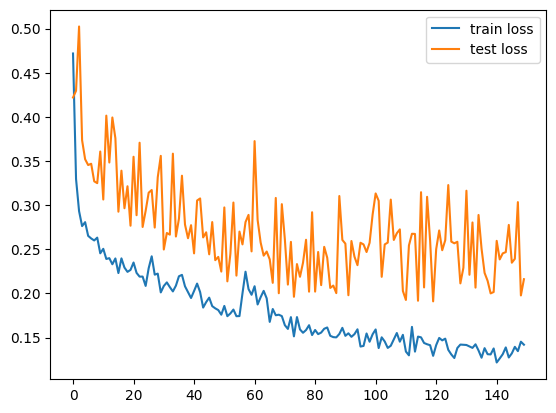

In [275]:
plt.plot(loss_list_train, label='train loss')
plt.plot(loss_list_test, label='test loss')
plt.legend()
plt.show()

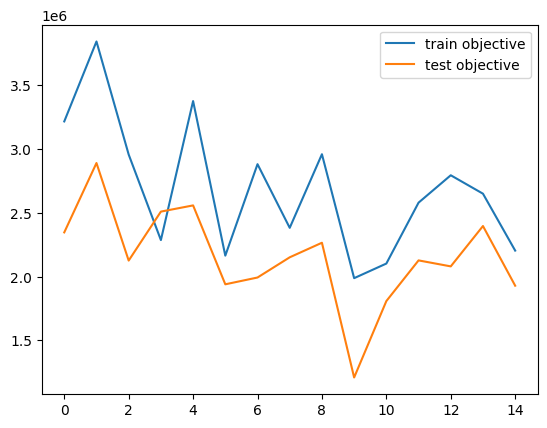

In [277]:
plt.plot(objvalue_train, label='train objective')
plt.plot(objvalue_test, label='test objective')
plt.legend()
plt.show()

In [134]:
def train_model(graph_loader, dataset, model, num_epoch,
                info={}, suffix='train', train=True):
    loss_list = []
    objvalue = []
    for epoch in range(num_epoch):
        ep_loss = []
        for graph in graph_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
            loss = operation_loss + service_loss
            loss.backward()
            optim.step()
            ep_loss.append(loss.item())
        loss_list.append(np.mean(ep_loss))
        

        if (epoch + 1) % 10 == 0:
            objvalue.append(validate_objective(model, dataset))
    info[f'{suffix}_loss'] = loss_list
    info[f'{suffix}_objvalue'] = objvalue
    return info

In [135]:
for i in trange(15):
    model.train()
    info = train_model(train_loader, train_dataset, model, 10)
    model.eval()
    with torch.no_grad():
        info = train_model(test_loader, test_dataset, model, 10,
                        info=info, suffix='test', train=False)

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

min train_loss loss:  0.7410446660859245
min test_loss loss:  0.742159515619278


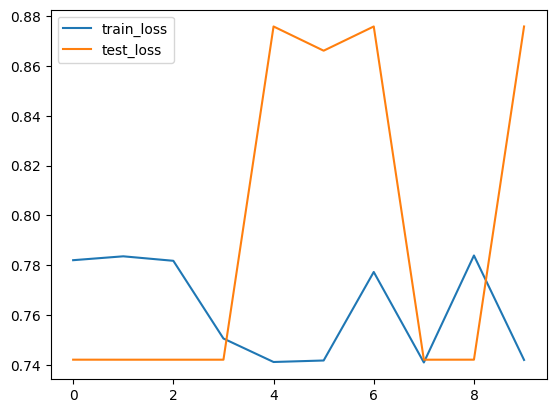

min train_objvalue objvalue:  8389833.790370595
min test_objvalue objvalue:  6670260.831722477


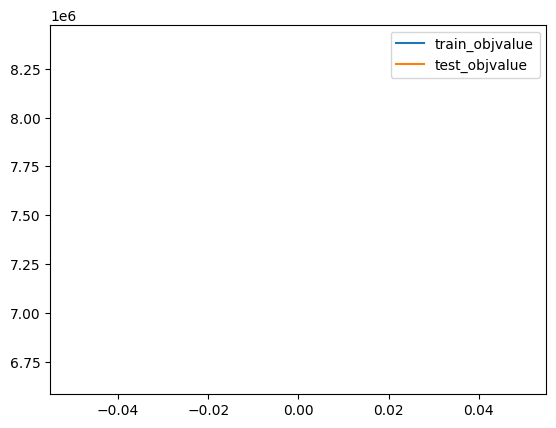

In [136]:
print_info(info)